In [129]:
###-----------------------------------###
###        import library             ###
###-----------------------------------###
##-- Pandas
import pandas as pd
from pandas import Series, DataFrame
##-- Numpy
import numpy as np
##-- Matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm # for gradation
import seaborn as sns
##-- Scikit-learn
import sklearn  #-- print(sklearn.__version__)
##-- GPy(Gaussian process)
##-- https://github.com/SheffieldML/GPy
import GPy

In [130]:
##-- Load the boston house-prices dataset from sklearn
##-- https://scikit-learn.org/stable/datasets/index.html#boston-dataset
from sklearn.datasets import load_boston
dataset = load_boston()
samples, label, feature_names = dataset.data, dataset.target, dataset.feature_names

In [131]:
f = pd.DataFrame(dataset.data)
f.columns = dataset.feature_names
f["PRICES"] = dataset.target
f.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICES
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


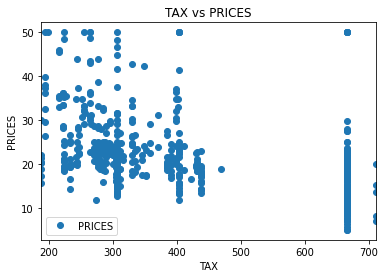

In [132]:
##-- Ex. "RM" vs "PRICE"
f.plot(x="TAX", y="PRICES", style="o")
plt.title("TAX vs PRICES")
plt.ylabel("PRICES")
plt.show()

In [133]:
##-- feature name to use
TargetName = "PRICES"
FeaturesName = [\
              #-- "Crime occurrence rate per unit population by town"
              "CRIM",\
              #-- "Percentage of 25000-squared-feet-area house"
              'ZN',\
              #-- "Percentage of non-retail land area by town"
              'INDUS',\
              #-- "Index for Charlse river: 0 is near, 1 is far"
              'CHAS',\
              #-- "Nitrogen compound concentration"
              'NOX',\
              #-- "Average number of rooms per residence"
              'RM',\
              #-- "Percentage of buildings built before 1940"
              'AGE',\
              #-- 'Weighted distance from five employment centers'
              "DIS",\
              ##-- "Index for easy access to highway"
              'RAD',\
              ##-- "Tax rate per $100,000"
              'TAX',\
              ##-- "Percentage of students and teachers in each town"
              'PTRATIO',\
              ##-- "1000(Bk - 0.63)^2, where Bk is the percentage of Black people"
              'B',\
              ##-- "Percentage of low-class population"
              'LSTAT',\
              ]

In [119]:
###-- Prepare explanatory variables(X) and Target variable(Y)
X = f[FeaturesName]
Y = f[TargetName]
###-- NOTE) Numpy.array is needed for GPy, prohibition of Pandas.Series 
X = np.array(X)
Y = np.array(Y)
###-- NOTE) GPy requires Y.ndim == 2
Y = np.reshape( Y, (Y.shape[0], 1) )

In [120]:
###--  Standardization  --###
from sklearn import preprocessing
sscaler = preprocessing.StandardScaler()
sscaler.fit(X)
X_std = sscaler.transform(X)
###-- Split the dataset(Train 8 : Test 2)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.2, random_state=99)

In [121]:
##-- GP: Gaussian Process
class GP_regression():
    
    def __init__(self, num_variable):
        import GPy
        self.kernel = GPy.kern.Matern52(num_variable, ARD=True)
        
    def __call__(self, X_train, Y_train):
        
        return self.train(X_train, Y_train)
    
    def train(self, X_train, Y_train):
        ##-- Train model
        model = GPy.models.GPRegression(\
                                        X_train, \
                                        Y_train, \
                                        kernel=self.kernel\
                                       )
        
        model.optimize()
        
        return model
        
    def predict(self, X_test):
        
        prediction = self.model(X_test)
        
        return prediction


In [122]:
##-- instanceをClassGP_regerssion"で定義
GP_pre = GP_regression(len(FeaturesName))
##-- GP modelを作成
model = GP_pre(X_train, Y_train)
##-- Prediction
y_pre = model.predict(X_test)[0]
sigma = model.predict(X_test)[1]
# print("Predicted mean:", y_pre[0])
# print("Variance at point X:", y_pre[1])

In [123]:
###-- MSE(Mean Squared Error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, y_pre)
print(mse)

10.708652542309926


In [124]:
###-- R^2(Coefficient of determination)
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, y_pre)
print(r2)

0.8850063502938952


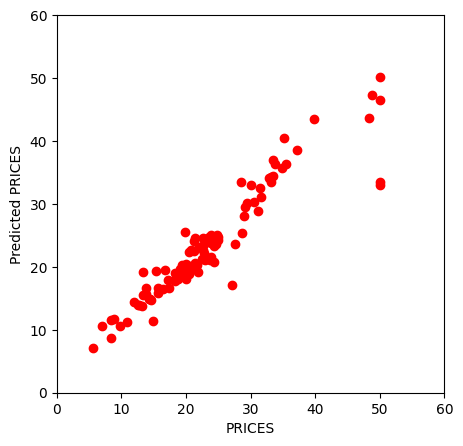

In [125]:
plt.figure(figsize=(5,5),dpi=100)
plt.xlabel("PRICES")
plt.ylabel("Predicted PRICES")
plt.xlim(0,60)
plt.ylim(0,60)
plt.plot(Y_test, y_pre, "or", color="red")
# plt.fill_between(Y_test[:, 0], y_pre[:, 0] - 0.2*sigma[:, 0], y_pre[:, 0] + 0.2*sigma[:, 0], color='gray', alpha=0.2)
plt.show()

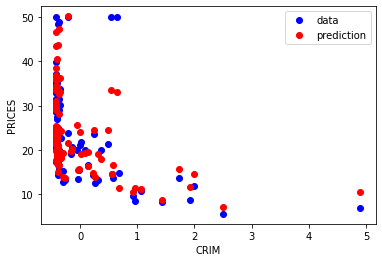

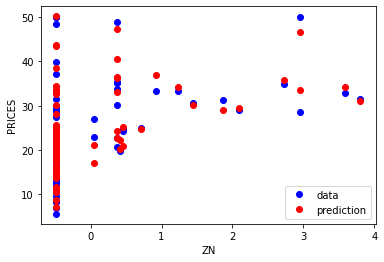

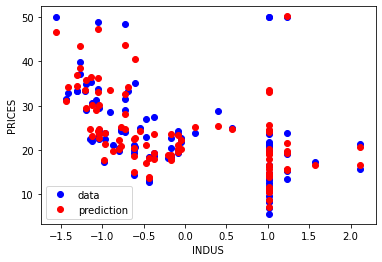

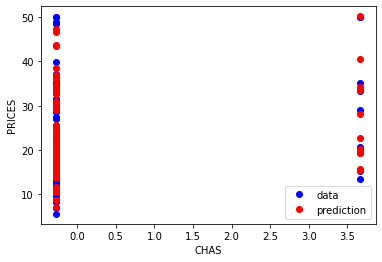

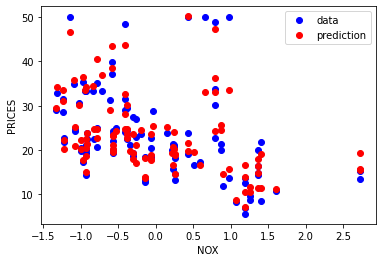

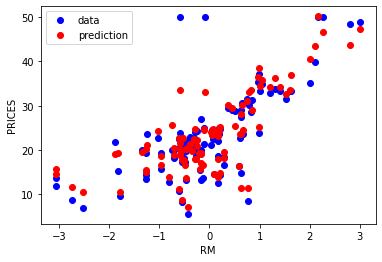

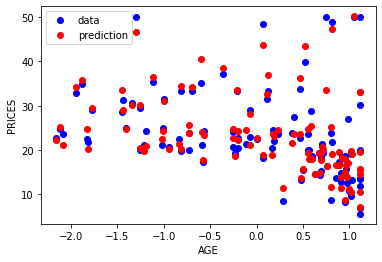

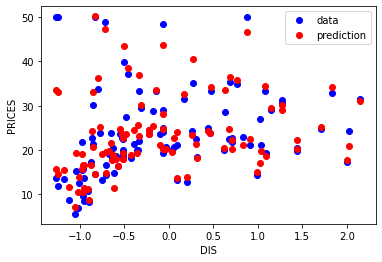

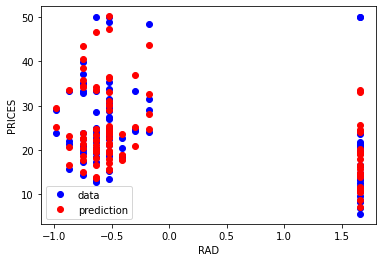

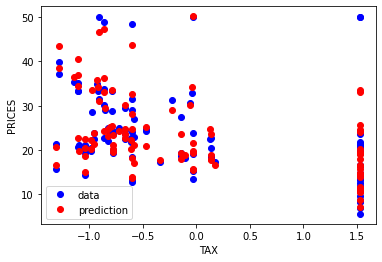

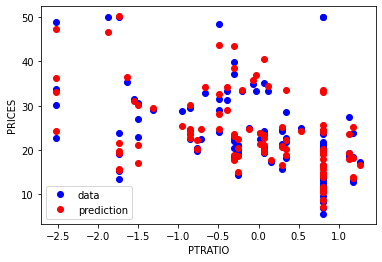

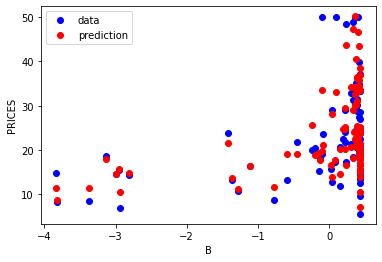

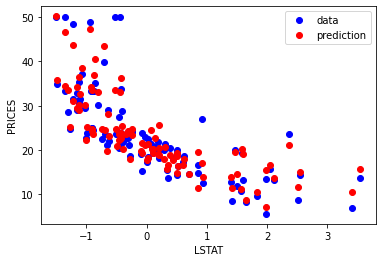

In [126]:
##-- Plot the results
g = pd.DataFrame(X_test)
g.columns = dataset.feature_names
for i in range(len(g.columns)):
    plt.plot(g[g.columns[i]], Y_test[:, 0], "or", color="blue", label="data")
    plt.plot(g[g.columns[i]], y_pre[:, 0], "or", color="red", label="prediction")
    # plt.title("*** vs PRICES")
    plt.xlabel(g.columns[i])
    plt.ylabel("PRICES")
    plt.legend()
    plt.show()